In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import defaultdict
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('PyTorch/GPU')
else:
    device = torch.device('cpu')
    print('PyTorch/CPU')

PyTorch/CPU


In [3]:
config = {
    'batch_size': 32,
    'learning_rate': 0.0002,
    'epochs': 10,
    'latent_size': 100,
    'data_size': 371,
    'model_dir': './',
    'embeding_size': 2,
}

In [4]:
features_df = pd.read_csv('preprocessed_features.csv')
print("features shape:", features_df.shape)

target_df = pd.read_csv('Encoded_target.csv')
print("available target lables:", target_df.columns.tolist())

sel_label =  'Arousal'
print(f"selected target label is '{sel_label}'")

features shape: (1280, 371)
available target lables: ['Valence', 'Arousal', 'Dominance', 'Liking']
selected target label is 'Arousal'


In [5]:
class DatasetDEAP(Dataset):
    
    def __init__(self, features_df, target_df, transform=None):
        assert len(features_df) == len(target_df)
        self.features = torch.FloatTensor(features_df.values)
        self.target = torch.FloatTensor(target_df.values)
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        features_ = self.features[index]
        if self.transform is not None:
            features_ = self.transform(features_)
        return features_, self.target[index]
    

data = DatasetDEAP(features_df, target_df["Arousal"])
data_loader = DataLoader(data, batch_size=config['batch_size'], shuffle=True)

In [6]:
batches = enumerate(data_loader)
batch_idx, (features_batch, target_batch) = next(batches)
print(features_batch.data.shape)
print(torch.min(features_batch.data), torch.max(features_batch.data))

torch.Size([32, 371])
tensor(-1.) tensor(1.)


In [7]:
class Generator(nn.Module):
    
    def __init__(self, input_size=config['latent_size'], embeding_size=config['embeding_size'],
                 output_size=config['data_size'], hidden_size=128):
        super(Generator, self).__init__()
        self.label_embeding = nn.Embedding(embeding_size, embeding_size)
        self.net = nn.Sequential(
                                 nn.Linear(input_size + embeding_size, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size*2, output_size),
                                 nn.Tanh()
                                )
        
    def forward(self, x, y):
        e = self.label_embeding(y)
        x = torch.cat([x, e], dim=1)
        x = self.net(x)
        return x

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size=config['data_size'], embeding_size=config['embeding_size'], hidden_size=128):
        super(Discriminator, self).__init__()
        self.label_embeding = nn.Embedding(embeding_size, embeding_size)
        self.net = nn.Sequential(
                                 nn.Linear(input_size + embeding_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size*2, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size, 1),
                                 nn.Sigmoid()
                                )
        
    def forward(self, x, y):
        e = self.label_embeding(y)
        x = torch.cat([x, e], dim=1)
        x = self.net(x)
        return x

In [9]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['learning_rate'])
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'])

criterion = torch.nn.BCELoss()

In [19]:
def train_cgan(generator=generator, discriminator=discriminator, real_train_loader=data_loader, 
               batch_size=config['batch_size'], latent_size=config['latent_size'], 
               embeding_size=config['embeding_size'], num_epochs=10, save_models=True, 
               plot_losses=True, device='cpu'):
    
    generator.to(device)
    discriminator.to(device)
    
    # loop over epochs
    history = defaultdict(list)
    for epoch in range(num_epochs):
        
        d_loss = 0.
        g_loss = 0.

        # loop over batches in each epoch
        for (features, target) in real_train_loader:
            
            features = features.view(batch_size, -1).to(device)
            target = target.view(batch_size).type(torch.LongTensor).to(device)
            
            # train discriminator
            # --------------------------
            discriminator.train()
            generator.eval()
            
            preds = discriminator(features, target)
            real_loss = criterion(preds, torch.ones_like(preds).to(device))
            
            fake_target = torch.LongTensor(np.random.randint(0, embeding_size, batch_size)).to(device)
            fake_features = generator(torch.randn(batch_size, latent_size).to(device), fake_target)
            fake_preds = discriminator(fake_features, fake_target)
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds).to(device))
            
            discriminator_loss = real_loss + fake_loss
            discriminator.zero_grad();
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # train generator
            # --------------------------
            generator.train()
            discriminator.eval()
            
            forged_target = torch.LongTensor(np.random.randint(0, embeding_size, batch_size)).to(device)
            forged_feafures = generator(torch.randn(batch_size, latent_size).to(device), forged_target)
            forged_preds = discriminator(forged_feafures, forged_target)
            forged_loss = criterion(forged_preds, torch.ones_like(forged_preds).to(device))
            
            generator.zero_grad();
            forged_loss.backward()
            generator_optimizer.step()
            
            # losses
            d_loss += discriminator_loss
            g_loss += forged_loss
            
        # statistics
        d_loss /= len(real_train_loader)
        g_loss /= len(real_train_loader)   
        print("epoch: {}/{}, d_loss:{:.5f}, g_loss:{:.5f}".format(epoch+1, num_epochs, d_loss, g_loss))
        history['g_losses'].append(g_loss.data.item())
        history['d_losses'].append(d_loss.data.item())
        
    # Save the model checkpoints 
    if save_models:
        torch.save(generator.state_dict(), 'model-gen.ckpt')
        torch.save(discriminator.state_dict(), 'model-discr.ckpt')
    
    # plot losses
    if plot_losses:
        plt.plot(history['g_losses'], label='generator')
        plt.plot(history['d_losses'], label='discriminator')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    
    return history

epoch: 1/500, d_loss:1.01603, g_loss:0.56773
epoch: 2/500, d_loss:1.16908, g_loss:0.60547
epoch: 3/500, d_loss:0.95320, g_loss:0.87999
epoch: 4/500, d_loss:0.77158, g_loss:1.25359
epoch: 5/500, d_loss:0.44329, g_loss:2.17769
epoch: 6/500, d_loss:0.15146, g_loss:3.16496
epoch: 7/500, d_loss:0.20466, g_loss:2.81015
epoch: 8/500, d_loss:0.47518, g_loss:2.04944
epoch: 9/500, d_loss:0.80331, g_loss:1.61764
epoch: 10/500, d_loss:1.07933, g_loss:1.58363
epoch: 11/500, d_loss:0.81376, g_loss:1.85633
epoch: 12/500, d_loss:0.62285, g_loss:1.95558
epoch: 13/500, d_loss:0.46064, g_loss:2.48976
epoch: 14/500, d_loss:0.44623, g_loss:2.34624
epoch: 15/500, d_loss:0.39924, g_loss:2.76209
epoch: 16/500, d_loss:0.42513, g_loss:2.53038
epoch: 17/500, d_loss:0.35048, g_loss:2.66978
epoch: 18/500, d_loss:0.36963, g_loss:2.62140
epoch: 19/500, d_loss:0.48087, g_loss:2.13313
epoch: 20/500, d_loss:0.60006, g_loss:1.83887
epoch: 21/500, d_loss:0.77535, g_loss:1.66433
epoch: 22/500, d_loss:0.75053, g_loss:1.772

epoch: 178/500, d_loss:1.15690, g_loss:0.99539
epoch: 179/500, d_loss:1.04820, g_loss:1.09236
epoch: 180/500, d_loss:1.12307, g_loss:1.10578
epoch: 181/500, d_loss:1.21821, g_loss:1.01177
epoch: 182/500, d_loss:1.28394, g_loss:0.89274
epoch: 183/500, d_loss:1.08472, g_loss:1.10513
epoch: 184/500, d_loss:1.13386, g_loss:1.07564
epoch: 185/500, d_loss:1.16036, g_loss:1.08424
epoch: 186/500, d_loss:1.12869, g_loss:1.19323
epoch: 187/500, d_loss:1.09447, g_loss:1.23476
epoch: 188/500, d_loss:1.14557, g_loss:1.01639
epoch: 189/500, d_loss:1.10325, g_loss:1.13455
epoch: 190/500, d_loss:1.11714, g_loss:1.10815
epoch: 191/500, d_loss:1.25190, g_loss:0.97716
epoch: 192/500, d_loss:1.08937, g_loss:1.08980
epoch: 193/500, d_loss:1.13002, g_loss:1.06691
epoch: 194/500, d_loss:1.25610, g_loss:0.89040
epoch: 195/500, d_loss:1.14423, g_loss:1.06354
epoch: 196/500, d_loss:1.14502, g_loss:1.01766
epoch: 197/500, d_loss:1.11649, g_loss:1.06613
epoch: 198/500, d_loss:1.11011, g_loss:1.07045
epoch: 199/50

epoch: 353/500, d_loss:1.25261, g_loss:0.85225
epoch: 354/500, d_loss:1.28087, g_loss:0.88001
epoch: 355/500, d_loss:1.26372, g_loss:0.85026
epoch: 356/500, d_loss:1.29420, g_loss:0.90633
epoch: 357/500, d_loss:1.16324, g_loss:1.02824
epoch: 358/500, d_loss:1.34126, g_loss:0.81625
epoch: 359/500, d_loss:1.22967, g_loss:1.03972
epoch: 360/500, d_loss:1.32698, g_loss:0.78673
epoch: 361/500, d_loss:1.28807, g_loss:0.87843
epoch: 362/500, d_loss:1.21386, g_loss:1.02123
epoch: 363/500, d_loss:1.30844, g_loss:0.83626
epoch: 364/500, d_loss:1.30873, g_loss:0.85434
epoch: 365/500, d_loss:1.13600, g_loss:0.98506
epoch: 366/500, d_loss:1.38384, g_loss:0.73991
epoch: 367/500, d_loss:1.18027, g_loss:0.93025
epoch: 368/500, d_loss:1.31411, g_loss:0.81883
epoch: 369/500, d_loss:1.15825, g_loss:1.01335
epoch: 370/500, d_loss:1.29660, g_loss:0.88860
epoch: 371/500, d_loss:1.24682, g_loss:0.88053
epoch: 372/500, d_loss:1.25251, g_loss:0.89161
epoch: 373/500, d_loss:1.24999, g_loss:0.89411
epoch: 374/50

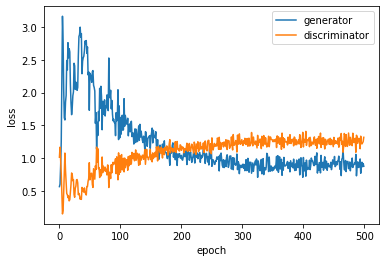

In [11]:
history = train_cgan(num_epochs=500, device=device)

In [16]:
def generate_cgan_data(generator=generator, n_samples=1, latent_size=config['latent_size'], 
                      embeding_size=config['embeding_size'], device='cpu'):
    
    gan_target = torch.LongTensor(np.random.randint(0, embeding_size, n_samples)).to(device)
    gan_feafures = generator(torch.randn(n_samples, latent_size).to(device), gan_target)
    return np.array(gan_feafures.data), np.array(gan_target)

GAN shape: (5000, 371)


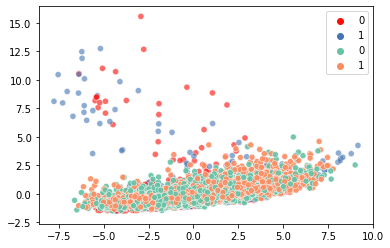

In [17]:
# real data
pca = PCA(n_components=2)
pca.fit(features_df.values)
features_pca = pca.transform(features_df.values)
sns.set_palette(sns.color_palette(["#FF0B04", "#4374B3"]))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target_df['Arousal'], alpha=0.6)

# GAN data
gan_features, gan_target = generate_cgan_data(n_samples=5000)
print("GAN shape:", gan_features.shape)
gan_features_pca = pca.transform(gan_features)
sns.set_palette(sns.color_palette("Set2"))
sns.scatterplot(x=gan_features_pca[:, 0], y=gan_features_pca[:, 1], hue=gan_target,
                color='k', alpha=0.9);

In [18]:
cgan_features_df = pd.DataFrame(gan_features, columns=features_df.columns)
cgan_features_df.to_csv("cgan_features.csv", index=False)
                                 
cgan_target_df = pd.DataFrame({sel_label: gan_target})
cgan_target_df.to_csv("cgan_target.csv", index=False)
# cgan_target_df.head()